In [1]:
import numpy as np
import torch
from cmb_ps import CMBPS
import matplotlib.pyplot as plt
from inference import *
import arviz as az

In [2]:
device = 0

In [3]:
ps_model = CMBPS(norm_phi=True).to(device)
#phi = sample_prior(5, device=device)
phi = torch.tensor([0.5, 0.5], device=device)
x = gen_x(phi, ps_model, device=device)

In [4]:
nchains = 20
nsamples = 100
burnin = 100
step_size = 0.001
nleap = 20
epsadapt = 0

sampler = infer(x,
                ps_model,
                nchains=nchains,
                nsamples=nsamples,
                burnin=burnin,
                step_size=step_size,
                nleap=nleap,
                epsadapt=epsadapt,
                device=device)

In [ ]:
samples = sampler.samples.cpu().numpy()
truth = phi.detach().cpu().numpy()

In [ ]:
samples.shape

In [ ]:
az_infdata = az.convert_to_inference_data(samples[:,:,:])

In [48]:
ess = az.ess(az_infdata) # See https://python.arviz.org/en/stable/api/generated/arviz.ess.html
rhat = az.rhat(az_infdata) # See https://python.arviz.org/en/stable/api/generated/arviz.rhat.html

print("ESS: ", ess['x'].values)
print("Rhat: ", rhat['x'].values)

ESS:  [464.93427536 603.34539742]
Rhat:  [1.02796449 1.02074511]


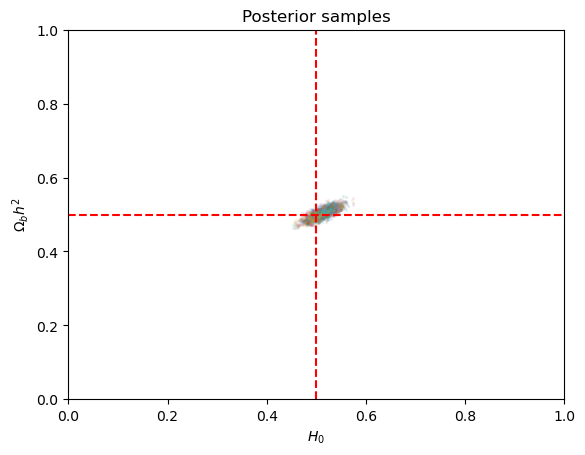

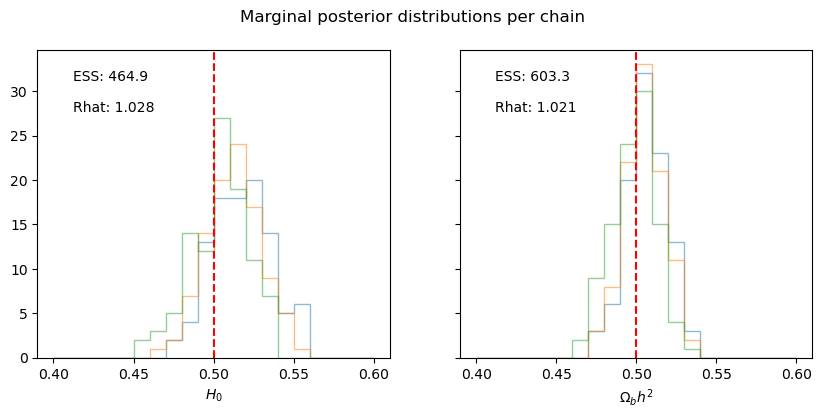

In [49]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()
for i in range(nchains):
    color = color_cycle[i % len(color_cycle)]
    plt.scatter(samples[i, :, 0], samples[i, :, 1], s=2, alpha=0.1, color=color)
plt.axvline(truth[0], color='red', linestyle='--')
plt.axhline(truth[1], color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Posterior samples")
plt.show()

chains_id = np.random.randint(0, nchains, 3)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i in chains_id:
    axs[0].hist(samples[i, :, 0], alpha=0.5, bins=20, range=(truth[0] - 0.1, truth[0] + 0.1), histtype='step')
    axs[1].hist(samples[i, :, 1], alpha=0.5, bins=20, range=(truth[1] - 0.1, truth[1] + 0.1), histtype='step')
axs[0].axvline(truth[0], color='red', linestyle='--')
axs[1].axvline(truth[1], color='red', linestyle='--')
axs[0].set_xlabel(r"$H_0$")
axs[1].set_xlabel(r"$\Omega_b h^2$")
for i in range(2):
    xmin, xmax = axs[i].get_xlim()
    ymin, ymax = axs[i].get_ylim()
    axs[i].text(xmin + 0.1*(xmax - xmin), ymax - 0.1*(ymax - ymin), "ESS: {:.1f}".format(ess['x'].values[i]))
    axs[i].text(xmin + 0.1*(xmax - xmin), ymax - 0.2*(ymax - ymin), "Rhat: {:.3f}".format(rhat['x'].values[i]))
plt.suptitle("Marginal posterior distributions per chain")
plt.show()